In [1]:
import sys

sys.path.append("./ml-fastvit")
import os
import timm
import torch
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as T
import torch.nn as nn
import models
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import gc

import cv2 as cv
from pathlib import Path
import pdb

from torch import Tensor
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.models import create_model
from models.modules.mobileone import reparameterize_model
from PIL import Image
from urllib.request import urlopen

from UpsampleTransformerDecoder import UpsampleTransformerDecoder

from object_detection_utils import (
    read_directory_names_from_file,
    imshow,
    display_segmentation_map,
)

# Before starting the training, make sure to clear any residual memory
gc.collect()
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first
cuda


In [2]:
def find_bounding_boxes(
    orig_image, seg_map, threshold=200, min_area_threshold=200, debug=False
):
    """
    Find bounding boxes of objects in an image based on a threshold.

    Parameters:
    image (numpy array): The input image.
    threshold (int): Threshold value for binary segmentation.
    min_area_threshold (int): Minimum area threshold for considering an object.
    debug (bool): If True, show the image with detected objects.

    Returns:
    List of bounding boxes in the format [xmin, ymin, xmax, ymax].
    """
    drawable = orig_image.copy()
    image = seg_map.astype(np.uint8)
    # Convert the image to grayscale if it's colored
    gray_image = (
        cv.cvtColor(image, cv.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    )

    # Apply a binary threshold to the image
    _, binary_image = cv.threshold(gray_image, threshold, 255, cv.THRESH_BINARY)

    # # Define kernel for morphological operations
    # kernel = np.ones((7, 7), np.uint8)

    # # Apply erosion and dilation
    # binary_image = cv.erode(binary_image, kernel, iterations=1)
    # binary_image = cv.dilate(binary_image, kernel, iterations=1)

    # Find connected components
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(
        binary_image, connectivity=8
    )

    bounding_boxes = []
    for i in range(1, num_labels):  # Skip label 0 as it's the background
        x, y, w, h, area = stats[i]
        # Check if the area of the blob is greater than the minimum threshold
        if area > min_area_threshold:
            xmin, ymin, xmax, ymax = x, y, x + w, y + h
            bounding_boxes.append([xmin, ymin, xmax, ymax])

            if debug:
                # Draw a rectangle and centroid for visualization
                cv.rectangle(drawable, (xmin, ymin), (xmax, ymax), (0, 0, 255), 3)
                cx, cy = centroids[i]
                cv.circle(drawable, (int(cx), int(cy)), 5, (0, 255, 0), -1)

    if debug:
        # Show the image with detected objects
        # plt.imshow(drawable)

        # Create a figure with 2x2 grid of axes
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))

        # Plot each image on its respective axes
        axs[0].imshow(binary_image)
        axs[0].axis("off")  # Turn off axis
        axs[0].set_title("Binary Image (raw)")

        axs[1].imshow(drawable)
        axs[1].axis("off")
        axs[1].set_title("Original image with bounding boxes")

    return bounding_boxes

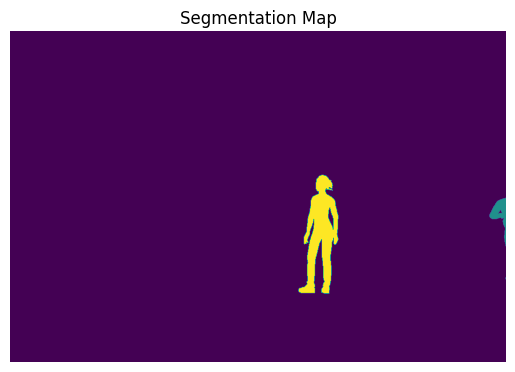

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [3]:
example_seg_map_path = "datasets/UBNormal/Scene1/abnormal_scene_1_scenario_2_annotations/abnormal_scene_1_scenario_2_0050_gt.png"
display_segmentation_map(example_seg_map_path)

#### Get list of training and test videos

In [4]:
# train_normal_vids_path = 'UBNormal/scripts/normal_training_video_names.txt'
# train_normal_vids = read_directory_names_from_file(train_normal_vids_path)
# print(len(train_normal_vids), train_normal_vids[:3])

train_abnormal_vids_path = "UBNormal/scripts/abnormal_training_video_names.txt"
train_abnormal_vids = read_directory_names_from_file(train_abnormal_vids_path)
print(len(train_abnormal_vids), train_abnormal_vids[:3])

# test_normal_vids_path = 'UBNormal/scripts/normal_test_video_names.txt'
# test_normal_vids = read_directory_names_from_file(test_normal_vids_path)
# print(len(test_normal_vids), test_normal_vids[:3])

# test_abnormal_vids_path = 'UBNormal/scripts/abnormal_test_video_names.txt'
# test_abnormal_vids = read_directory_names_from_file(test_abnormal_vids_path)
# print(len(test_abnormal_vids), test_abnormal_vids[:3])

82 ['abnormal_scene_27_scenario_8', 'abnormal_scene_13_scenario_6', 'abnormal_scene_3_scenario_4']


### Move videos to train / test directory (one-time)

In [5]:
# train_normal_vids_mp4 = [vid + ".mp4" for vid in train_normal_vids]
train_abnormal_vids_mp4 = [vid + ".mp4" for vid in train_abnormal_vids]
# test_normal_vids_mp4 = [vid + ".mp4" for vid in test_normal_vids]
# test_abnormal_vids_mp4 = [vid + ".mp4" for vid in test_abnormal_vids]

In [6]:
import os
import shutil


def copy_videos(src_directory, video_names, output_directory):
    """
    Copies videos from subfolders in src_directory to output_directory.

    Parameters:
    - src_directory: Path to the source directory containing subfolders.
    - video_names: List of video file names to search for.
    - output_directory: Path to the directory where videos will be copied.
    """
    # Ensure the output directory exists, create if not
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Iterate over all subdirectories in the source directory
    for subdir in os.listdir(src_directory):
        subdir_path = os.path.join(src_directory, subdir)
        if os.path.isdir(subdir_path):
            # Iterate over all files in the subdirectory
            for file in os.listdir(subdir_path):
                if file in video_names:
                    # Construct full paths for source and destination files
                    src_file_path = os.path.join(subdir_path, file)
                    dest_file_path = os.path.join(output_directory, file)

                    # Check if the file already exists in the destination
                    if not os.path.exists(dest_file_path):
                        # If the file is not in the destination, copy it
                        shutil.copy(src_file_path, output_directory)
                        print(f"Copied {file} to {output_directory}")
                    else:
                        print(
                            f"{file} already exists in {output_directory}, skipping copy."
                        )


# Example usage:
# video_list = ["video1.mp4", "video2.mp4", "video3.avi"]
# copy_videos("/path/to/source/directory", video_list, "/path/to/output/directory")

In [ ]:
# Source Directory
source_dir = "datasets/UBNormal/"

# Destination Directories
# train_normal_videos_dir = 'datasets/UBNormal/train_normal_videos/'
train_abnormal_videos_dir = "datasets/UBNormal/train_abnormal_videos/"
# test_normal_videos_dir = 'datasets/UBNormal/test_normal_videos/'
# test_abnormal_videos_dir = 'datasets/UBNormal/test_abnormal_videos'

# print("Running Train video copy...")
# copy_videos(source_dir, set(train_normal_vids_mp4), train_normal_videos_dir)

# print("Running Test video copy...")
# copy_videos(source_dir, set(test_normal_vids_mp4), test_normal_videos_dir)

copy_videos(source_dir, set(train_abnormal_vids_mp4), train_abnormal_videos_dir)

#### For each video create folder with all frames (one-time)

In [14]:
# train_normal_frames_dir = 'datasets/UBNormal/train_normal_frames/'
# train_abnormal_frames_dir = 'datasets/UBNormal/train_abnormal_frames/'
train_abnormal_objects_dir = (
    "datasets/UBNormal/train_anomalies_avenue_background_objects/"
)
# test_normal_frames_dir = 'datasets/UBNormal/test_normal_frames/'
# test_abnormal_frames_dir = 'datasets/UBNormal/test_abnormal_frames/'

In [15]:
import os


def create_subdirectories(directory_list, destination_directory):
    """
    Creates subdirectories in the given destination directory based on the provided list.

    Parameters:
    - directory_list: List of names of subdirectories to create.
    - destination_directory: The destination directory where subdirectories will be created.
    """
    for subdir in directory_list:
        # Construct the path for each subdirectory
        subdir_path = os.path.join(destination_directory, subdir)

        # Create the subdirectory if it doesn't already exist
        if not os.path.exists(subdir_path):
            os.makedirs(subdir_path)
            print(f"Created subdirectory: {subdir_path}")
        else:
            print(f"Subdirectory already exists: {subdir_path}")

In [16]:
# # Example usage:
# # dirs_to_create = ["subdir1", "subdir2", "subdir3"]
# # destination = "/path/to/destination/directory"
# create_subdirectories(train_normal_vids, train_normal_frames_dir)
create_subdirectories(train_abnormal_vids, train_abnormal_objects_dir)
# create_subdirectories(test_normal_vids, test_normal_frames_dir)
# create_subdirectories(test_normal_vids, test_abnormal_frames_dir)

Created subdirectory: datasets/UBNormal/train_anomalies_avenue_background_objects/abnormal_scene_27_scenario_8
Created subdirectory: datasets/UBNormal/train_anomalies_avenue_background_objects/abnormal_scene_13_scenario_6
Created subdirectory: datasets/UBNormal/train_anomalies_avenue_background_objects/abnormal_scene_3_scenario_4
Created subdirectory: datasets/UBNormal/train_anomalies_avenue_background_objects/abnormal_scene_20_scenario_8
Created subdirectory: datasets/UBNormal/train_anomalies_avenue_background_objects/abnormal_scene_4_scenario_10
Created subdirectory: datasets/UBNormal/train_anomalies_avenue_background_objects/abnormal_scene_12_scenario_6
Created subdirectory: datasets/UBNormal/train_anomalies_avenue_background_objects/abnormal_scene_3_scenario_7
Created subdirectory: datasets/UBNormal/train_anomalies_avenue_background_objects/abnormal_scene_14_scenario_3
Created subdirectory: datasets/UBNormal/train_anomalies_avenue_background_objects/abnormal_scene_8_scenario_4_fog


### For each video, write the frames to the subdirectory (one-time)

In [25]:
def format_frame_idx(number):
    return "{:04d}".format(number)


# Example usage:
frame_index = 1
formatted_frame_index = format_frame_idx(frame_index)
print(formatted_frame_index)  # Output: "0001"

0001


In [26]:
import cv2
import os


def save_video_frames(video_path, output_directory):
    """
    Extracts frames from a video and saves them in the specified directory.

    Parameters:
    - video_path: Path to the video file.
    - output_directory: Directory where frames will be saved.
    """
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    # Loop to read each frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Break the loop if there are no frames left

        # Construct the frame name based on the given naming convention
        frame_name = f"{video_path.split('/')[-1].split('.')[0]}_{format_frame_idx(frame_count)}.jpg"
        frame_path = os.path.join(output_directory, frame_name)

        # Save the frame
        cv2.imwrite(frame_path, frame)
        frame_count += 1

    # Release the VideoCapture object
    cap.release()

In [9]:
# Source
# train_normal_videos_dir = 'datasets/UBNormal/train_normal_videos/'
train_abnormal_videos_dir = "datasets/UBNormal/train_abnormal_videos/"
# test_normal_videos_dir = 'datasets/UBNormal/test_normal_videos/'
# test_abnormal_videos_dir = 'datasets/UBNormal/test_abnormal_videos/'

# Dest
# train_normal_frames_dir = 'datasets/UBNormal/train_normal_frames/'
train_abnormal_frames_dir = "datasets/UBNormal/train_abnormal_frames/"
# test_normal_frames_dir = 'datasets/UBNormal/test_normal_frames/'
# test_abnormal_frames_dir = 'datasets/UBNormal/test_abnormal_frames/'

In [58]:
# for i, vid_name in enumerate(sorted(train_normal_vids_mp4)):
#     vid_name_without_mp4 = vid_name.split('.')[0]
#     print("Video name: ", vid_name)
#     video_path = os.path.join(train_normal_videos_dir, vid_name)
#     output_path = os.path.join(train_normal_frames_dir, vid_name_without_mp4)
#     save_video_frames(video_path, output_path)

In [28]:
for i, vid_name in enumerate(sorted(train_abnormal_vids_mp4)):
    vid_name_without_mp4 = vid_name.split(".")[0]
    print("Video path: ", vid_name)
    video_path = os.path.join(train_abnormal_videos_dir, vid_name)
    output_path = os.path.join(train_abnormal_frames_dir, vid_name_without_mp4)
    save_video_frames(video_path, output_path)

Video path:  abnormal_scene_11_scenario_3.mp4
Video path:  abnormal_scene_11_scenario_3_fog.mp4
Video path:  abnormal_scene_11_scenario_4_fog.mp4
Video path:  abnormal_scene_11_scenario_5.mp4
Video path:  abnormal_scene_11_scenario_7.mp4
Video path:  abnormal_scene_12_scenario_5.mp4
Video path:  abnormal_scene_12_scenario_6.mp4
Video path:  abnormal_scene_12_scenario_7.mp4
Video path:  abnormal_scene_13_scenario_6.mp4
Video path:  abnormal_scene_14_scenario_2.mp4
Video path:  abnormal_scene_14_scenario_3.mp4
Video path:  abnormal_scene_14_scenario_4.mp4
Video path:  abnormal_scene_16_scenario_5.mp4
Video path:  abnormal_scene_16_scenario_6.mp4
Video path:  abnormal_scene_16_scenario_7.mp4
Video path:  abnormal_scene_16_scenario_8.mp4
Video path:  abnormal_scene_17_scenario_8.mp4
Video path:  abnormal_scene_18_scenario_1.mp4
Video path:  abnormal_scene_18_scenario_2.mp4
Video path:  abnormal_scene_18_scenario_3.mp4
Video path:  abnormal_scene_18_scenario_4.mp4
Video path:  abnormal_scen

In [59]:
# for i, vid_name in enumerate(sorted(test_normal_vids_mp4)):
#     vid_name_without_mp4 = vid_name.split('.')[0]
#     print("Video path: ", vid_name)
#     video_path = os.path.join(test_normal_videos_dir, vid_name)
#     output_path = os.path.join(test_normal_frames_dir, vid_name_without_mp4)
#     save_video_frames(video_path, output_path)

In [23]:
# for i, vid_name in enumerate(sorted(test_abnormal_vids_mp4)):
#     vid_name_without_mp4 = vid_name.split('.')[0]
#     print("Video path: ", vid_name)
#     video_path = os.path.join(test_abnormal_videos_dir, vid_name)
#     output_path = os.path.join(test_abnormal_frames_dir, vid_name_without_mp4)
#     save_video_frames(video_path, output_path)

Video path:  abnormal_scene_10_scenario_1.mp4
Video path:  abnormal_scene_10_scenario_3.mp4
Video path:  abnormal_scene_10_scenario_4.mp4
Video path:  abnormal_scene_10_scenario_5.mp4
Video path:  abnormal_scene_10_scenario_6.mp4
Video path:  abnormal_scene_10_scenario_7.mp4
Video path:  abnormal_scene_10_scenario_8.mp4
Video path:  abnormal_scene_11_scenario_1.mp4
Video path:  abnormal_scene_11_scenario_1_fog.mp4
Video path:  abnormal_scene_11_scenario_2.mp4
Video path:  abnormal_scene_11_scenario_2_fog.mp4
Video path:  abnormal_scene_11_scenario_8.mp4
Video path:  abnormal_scene_11_scenario_9.mp4
Video path:  abnormal_scene_12_scenario_1.mp4
Video path:  abnormal_scene_12_scenario_1_smoke.mp4
Video path:  abnormal_scene_12_scenario_2.mp4
Video path:  abnormal_scene_12_scenario_3.mp4
Video path:  abnormal_scene_12_scenario_4.mp4
Video path:  abnormal_scene_12_scenario_8.mp4
Video path:  abnormal_scene_12_scenario_9.mp4
Video path:  abnormal_scene_13_scenario_1.mp4
Video path:  abnorma

### TODO
- Take each video name (without mp4) and create the annotation structure name. Do this for train and test (check we got the name convention right).
- Apply the copy_directories function, so we'll end up having the annotations to all train vids in one parent dir.

- To create object predictions on train set, we can use our standard YoloV8 flow for predictions. Experiment with the thresholds.

- To create objects: We can use the segmentation maps to create bounding boxes. The bounding boxes will have to be coupled with the object in the original image, so we'll have to pair frame and annotation and iterate through them together. We can use our optical flow function after for extraction of bounding boxes. This will be extremely useful for constructing the ground truth for test set in RBDC / TBDC / AUC computation.


- To understand: How to create the test tracks? We will know how to get the bounding boxes of a segmentation map (so no need for original image), but how will tracks be formed? Do we only take the frames included in the `track.txt`?

### Creating Tracks

In [44]:
# path to the data set
base_input_folder = "./datasets/UBNormal/"
# path to the output folder
# output_folder = "./tracks/tracks_ubnormal/tracks_test"
output_folder = "./tracks/tracks_ubnormal/tracks_train"
os.makedirs(output_folder, exist_ok=True)
# paths to the video names
abnormal_video_names_path = "./UBNormal/scripts/abnormal_training_video_names.txt"
normal_video_names_path = "./UBNormal/scripts/normal_training_video_names.txt"

abnormal_video_names = np.loadtxt(abnormal_video_names_path, dtype=str)
normal_video_names = np.loadtxt(normal_video_names_path, dtype=str)

print(abnormal_video_names[:3])

['abnormal_scene_27_scenario_8' 'abnormal_scene_13_scenario_6'
 'abnormal_scene_3_scenario_4']


In [13]:
class Bbox:
    def __init__(
        self, x_min: int, y_min: int, x_max: int, y_max: int, is_abnormal: bool = False
    ):
        self.x_min: int = x_min
        self.y_min: int = y_min
        self.x_max: int = x_max
        self.y_max: int = y_max
        self.is_abnormal = is_abnormal


def load_tracks(tracks_path):
    tracks = np.loadtxt(tracks_path, delimiter=",")

    if tracks.ndim == 1:
        tracks = [tracks]
    return np.array(tracks)


def count_frames(path):
    # grab a pointer to the video file and initialize the total
    # number of frames read
    video = cv.VideoCapture(path)
    total = 0
    total = int(video.get(cv.CAP_PROP_FRAME_COUNT))

    # release the video file pointer
    video.release()
    # return the total number of frames in the video
    return total


def compute_total_num_frames(video_names):
    total_num_frames = 0

    for video_name in video_names:
        scene_name = video_name.split("_")[2]
        base_path = os.path.join(base_input_folder, f"Scene{scene_name}")
        video_path = os.path.join(base_path, f"{video_name}.mp4")
        print(f"Counting {video_path} ...")
        total_num_frames += count_frames(video_path)

    return total_num_frames


def get_bbox(frame) -> Bbox:
    contours, hierarchy = cv.findContours(
        np.uint8(frame * 255), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE
    )

    if len(contours) == 0:
        return None
    max_idx = 0
    max_area = 0
    for cnt_idx in range(len(contours)):
        x, y, w, h = cv.boundingRect(contours[cnt_idx])
        if w * h > max_area:
            max_area = w * h
            max_idx = cnt_idx

    x, y, w, h = cv.boundingRect(contours[max_idx])
    return Bbox(x_min=x, y_min=y, x_max=x + w, y_max=y + h)


def create_tracks(abnormal_video_names):
    for video_name in abnormal_video_names:
        scene_name = video_name.split("_")[2]
        base_path = os.path.join(base_input_folder, f"Scene{scene_name}")
        folder_annotation_path = os.path.join(base_path, f"{video_name}_annotations")
        tracks_path = os.path.join(folder_annotation_path, f"{video_name}_tracks.txt")
        if os.path.exists(
            os.path.join(folder_annotation_path, f"{video_name}_new_tracks.txt")
        ):
            tracks_path = os.path.join(
                folder_annotation_path, f"{video_name}_new_tracks.txt"
            )
        print(f"Computing tracks for {os.path.join(base_path, video_name)}...")
        tracks_np = load_tracks(tracks_path)
        tracks = tracks_np.tolist()
        tracks.sort(key=lambda track: track[0])
        results = []
        new_track_id = 0
        for track in tracks:
            track_id = int(track[0])

            start = int(track[1])
            end = int(track[2])

            for frame_idx in range(start, end + 1):
                gt_map_path = os.path.join(
                    folder_annotation_path, "%s_%04d_gt.png" % (video_name, frame_idx)
                )
                gt_map = cv.imread(gt_map_path, 0)
                assert gt_map is not None

                mask = (gt_map == track_id) * 1

                bbox = get_bbox(mask)

                res = np.array(
                    [
                        new_track_id,
                        frame_idx,
                        bbox.x_min,
                        bbox.y_min,
                        bbox.x_max,
                        bbox.y_max,
                    ]
                )
                # print(res)
                results.append(res)
            new_track_id += 1
        # print("Track path file for RBDC contains:")
        # print(results)
        rbdc_tbdc_tracks_path = os.path.join(output_folder, f"{video_name}.txt")
        np.savetxt(rbdc_tbdc_tracks_path, results, delimiter=",", fmt="%d")

In [45]:
create_tracks(abnormal_video_names)

Computing tracks for ./datasets/UBNormal/Scene27/abnormal_scene_27_scenario_8...
Computing tracks for ./datasets/UBNormal/Scene13/abnormal_scene_13_scenario_6...
Computing tracks for ./datasets/UBNormal/Scene3/abnormal_scene_3_scenario_4...
Computing tracks for ./datasets/UBNormal/Scene20/abnormal_scene_20_scenario_8...
Computing tracks for ./datasets/UBNormal/Scene4/abnormal_scene_4_scenario_10...
Computing tracks for ./datasets/UBNormal/Scene12/abnormal_scene_12_scenario_6...
Computing tracks for ./datasets/UBNormal/Scene3/abnormal_scene_3_scenario_7...
Computing tracks for ./datasets/UBNormal/Scene14/abnormal_scene_14_scenario_3...
Computing tracks for ./datasets/UBNormal/Scene8/abnormal_scene_8_scenario_4_fog...
Computing tracks for ./datasets/UBNormal/Scene27/abnormal_scene_27_scenario_5...
Computing tracks for ./datasets/UBNormal/Scene29/abnormal_scene_29_scenario_5...
Computing tracks for ./datasets/UBNormal/Scene23/abnormal_scene_23_scenario_5...
Computing tracks for ./datasets

In [ ]:
# create_tracks(abnormal_video_names)
print("Computing total number of frames...")
num_abnormal_frames = compute_total_num_frames(abnormal_video_names)
num_normal_frames = compute_total_num_frames(normal_video_names)
total_num_frames = num_abnormal_frames + num_normal_frames
print(f"There are a total of {total_num_frames} frames")
# # val 29071 frames
# # test 89908 frames -> mine says 92640
# # test abnormal frames: 69047
# Train frames: 116087; Abnormal train frames: 36584 (in total, probably);

In [15]:
num_abnormal_frames

36584

### Create Anomaly Ground Truths

In [46]:
import glob
from enum import Enum
import sys

import cv2 as cv
import scipy.io as sio
from sklearn import metrics
import pickle
import pdb
import numpy as np
import os
import matplotlib.pyplot as plt

sys.path.append("./abnorm_event_detect/evaluation/")
os.chdir("abnorm_event_detect")

from evaluation.merge_tracks import ContinuousTrack

os.chdir("..")

!pwd

from evaluation.merge_tracks import ContinuousTrack

/mnt/c/Users/Sergiu/Desktop/AnomalyDetection


In [47]:
class TrackState(Enum):
    CREATED = "created"
    UPDATED = "updated"
    CLOSED = "closed"


class Track:
    def __init__(self, start_idx=0, end_idx=None, mask=0, video_name=""):
        self.start_idx = start_idx
        self.end_idx = end_idx
        self.bboxes = {}
        self.mask = mask
        self.state = TrackState.CREATED
        self.video_name = video_name

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)


class AnomalyDetection:
    def __init__(self, frame_idx, bbox, score, video_name, track_id=-1):
        self.frame_idx = frame_idx
        self.bbox = bbox
        self.score = score
        self.video_name = video_name
        self.track_id = track_id

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

In [48]:
abnormal_train_vid_names = read_directory_names_from_file(
    "UBnormal/scripts/abnormal_training_video_names.txt"
)
print(len(abnormal_train_vid_names), abnormal_train_vid_names[:3])

82 ['abnormal_scene_27_scenario_8', 'abnormal_scene_13_scenario_6', 'abnormal_scene_3_scenario_4']


In [49]:
test_frame_mask_dict = {}


def create_tracks_obj(abnormal_video_names):
    all_tracks_obj = []

    for video_name in abnormal_video_names:
        scene_name = video_name.split("_")[2]
        base_path = os.path.join(base_input_folder, f"Scene{scene_name}")
        folder_annotation_path = os.path.join(base_path, f"{video_name}_annotations")
        tracks_path = os.path.join(folder_annotation_path, f"{video_name}_tracks.txt")

        if os.path.exists(
            os.path.join(folder_annotation_path, f"{video_name}_new_tracks.txt")
        ):
            tracks_path = os.path.join(
                folder_annotation_path, f"{video_name}_new_tracks.txt"
            )
        print(f"Computing tracks for {os.path.join(base_path, video_name)}...")

        tracks_np = load_tracks(tracks_path)
        tracks = tracks_np.tolist()
        tracks.sort(key=lambda track: track[0])
        results = []
        new_track_id = 0

        test_frame_mask_dict[video_name] = []

        for track in tracks:
            # Get initial stats for track
            track_id = int(track[0])
            start = int(track[1])
            end = int(track[2])

            # Create track object
            track_obj = Track(start_idx=start, end_idx=end, video_name=video_name)

            for frame_idx in range(start, end + 1):
                gt_map_path = os.path.join(
                    folder_annotation_path, "%s_%04d_gt.png" % (video_name, frame_idx)
                )
                gt_map = cv.imread(gt_map_path, 0)
                assert gt_map is not None

                mask = (gt_map == track_id) * 1

                # Get bounding box
                bbox = get_bbox(mask)

                # Add bounding box to track obj bounding boxes
                track_obj.bboxes[frame_idx] = [
                    int(bbox.x_min),
                    int(bbox.y_min),
                    int(bbox.x_max),
                    int(bbox.y_max),
                ]

                res = np.array(
                    [
                        new_track_id,
                        frame_idx,
                        bbox.x_min,
                        bbox.y_min,
                        bbox.x_max,
                        bbox.y_max,
                    ]
                )
                # print(res)
                results.append(res)
            new_track_id += 1

        all_tracks_obj.append(track_obj)

    return all_tracks_obj
    # print("Track path file for RBDC contains:")
    # print(results)
    # rbdc_tbdc_tracks_path = os.path.join(output_folder, f"{video_name}.txt")
    # np.savetxt(rbdc_tbdc_tracks_path, results, delimiter=",", fmt="%d")

In [60]:
# path to the data set
base_input_folder = "./datasets/UBNormal/"
# path to the output folder
# output_folder = "./tracks/tracks_ubnormal/tracks_test"
# os.makedirs(output_folder, exist_ok=True)
# # paths to the video names
# abnormal_video_names_path = "./UBNormal/scripts/abnormal_test_video_names.txt"
# normal_video_names_path = "./UBNormal/scripts/normal_test_video_names.txt"

output_folder = "./tracks/tracks_ubnormal/tracks_train"
os.makedirs(output_folder, exist_ok=True)
# paths to the video names
abnormal_video_names_path = "./UBNormal/scripts/abnormal_training_video_names.txt"
normal_video_names_path = "./UBNormal/scripts/normal_training_video_names.txt"

abnormal_video_names = np.loadtxt(abnormal_video_names_path, dtype=str)
normal_video_names = np.loadtxt(normal_video_names_path, dtype=str)

In [61]:
all_gt_tracks = create_tracks_obj(abnormal_video_names)

Computing tracks for ./datasets/UBNormal/Scene27/abnormal_scene_27_scenario_8...
Computing tracks for ./datasets/UBNormal/Scene13/abnormal_scene_13_scenario_6...
Computing tracks for ./datasets/UBNormal/Scene3/abnormal_scene_3_scenario_4...
Computing tracks for ./datasets/UBNormal/Scene20/abnormal_scene_20_scenario_8...
Computing tracks for ./datasets/UBNormal/Scene4/abnormal_scene_4_scenario_10...
Computing tracks for ./datasets/UBNormal/Scene12/abnormal_scene_12_scenario_6...
Computing tracks for ./datasets/UBNormal/Scene3/abnormal_scene_3_scenario_7...
Computing tracks for ./datasets/UBNormal/Scene14/abnormal_scene_14_scenario_3...
Computing tracks for ./datasets/UBNormal/Scene8/abnormal_scene_8_scenario_4_fog...
Computing tracks for ./datasets/UBNormal/Scene27/abnormal_scene_27_scenario_5...
Computing tracks for ./datasets/UBNormal/Scene29/abnormal_scene_29_scenario_5...
Computing tracks for ./datasets/UBNormal/Scene23/abnormal_scene_23_scenario_5...
Computing tracks for ./datasets

In [67]:
len(all_gt_tracks)

194

In [68]:
# test_frame_mask_dict

In [70]:
# # Save the object to a file
# with open('ubnormal_all_test_gt_tracks', 'wb') as file:
#     pickle.dump(all_gt_tracks, file)

with open("ubnormal_all_train_gt_tracks", "wb") as file:
    pickle.dump(all_gt_tracks, file)

In [43]:
# Import pickle file
# import pickle
# with open('ubnormal_all_test_gt_tracks', 'rb') as file:
#     all_gt_tracks = pickle.load(file)

with open("ubnormal_all_train_gt_tracks", "rb") as file:
    all_gt_tracks = pickle.load(file)

In [71]:
# Get GT for RBDC and TBDC
# all_gt_tracks = []
# num_tracks = 0

# for vn, pkl_file in zip(video_names, pkl_files):
#     tracks = pickle.load(open(os.path.join(pkl_file), 'rb'))
#     all_gt_tracks += tracks

num_tracks = len(all_gt_tracks)
print("All GT Tracks: ", num_tracks, all_gt_tracks[:2])

gt_anomalies = []
for track_id, track in enumerate(all_gt_tracks):
    for frame_idx, bbox in track.bboxes.items():
        gt_anomalies.append(
            AnomalyDetection(frame_idx, bbox, 1, track.video_name, track_id=track_id)
        )

print("GT Anomalies: ", len(gt_anomalies), gt_anomalies[:2])

All GT Tracks:  194 [<__main__.Track object at 0x7fc83933a710>, <__main__.Track object at 0x7fc83933ab60>]
GT Anomalies:  37040 [<__main__.AnomalyDetection object at 0x7fc839640d60>, <__main__.AnomalyDetection object at 0x7fc839640cd0>]


### Create Labels Anomaly Test Mask

- pt fiecare video, luam nr de frames si initializam array de 0 uri
- trecem prin all gt tracks si unde la un frame idx avem ceva (adica e prezent), marcam indexul aferent din labels cu 1
- trecem prin toate video-urile

In [73]:
def count_frames(path):
    # grab a pointer to the video file and initialize the total
    # number of frames read
    video = cv.VideoCapture(path)
    total = 0
    total = int(video.get(cv.CAP_PROP_FRAME_COUNT))

    # release the video file pointer
    video.release()
    # return the total number of frames in the video
    return total

In [74]:
# abnormal_test_vid_names = read_directory_names_from_file('UBnormal/scripts/abnormal_test_video_names.txt')
abnormal_train_vid_names = read_directory_names_from_file(
    "UBnormal/scripts/abnormal_training_video_names.txt"
)
# print(len(abnormal_test_vid_names), abnormal_test_vid_names[:3])
print(len(abnormal_train_vid_names), abnormal_train_vid_names[:3])

82 ['abnormal_scene_27_scenario_8', 'abnormal_scene_13_scenario_6', 'abnormal_scene_3_scenario_4']


In [75]:
# normal_test_vid_names = read_directory_names_from_file('UBnormal/scripts/normal_test_video_names.txt')
normal_train_vid_names = read_directory_names_from_file(
    "UBnormal/scripts/normal_training_video_names.txt"
)
print(len(normal_train_vid_names), normal_train_vid_names[:3])

186 ['normal_scene_13_scenario_5', 'normal_scene_11_scenario_6_1', 'normal_scene_10_scenario_4']


In [76]:
abnormal_test_masks = {}
abnormal_test_videos = "./datasets/UBNormal/train_abnormal_videos/"
normal_test_videos = "./datasets/UBNormal/train_normal_videos/"

# Initialize test mask labels
for vid_name in abnormal_test_vid_names:
    # Get frames for video
    full_path = os.path.join(abnormal_test_videos, vid_name + ".mp4")
    num_frames = count_frames(full_path)

    abnormal_test_masks[vid_name] = np.zeros((num_frames,), dtype="uint8")

# Go through all anomalies, and assign 1 to the video name and frame where there is an anomaly
for anomaly in gt_anomalies:
    abnormal_test_masks[anomaly.video_name][anomaly.frame_idx] = 1

# Initialize test mask labels for normal videos
for vid_name in normal_test_vid_names:
    # Get frames for video
    full_path = os.path.join(normal_test_videos, vid_name + ".mp4")
    num_frames = count_frames(full_path)

    abnormal_test_masks[vid_name] = np.zeros((num_frames,), dtype="uint8")

In [ ]:
abnormal_test_masks

In [78]:
# Save the object to a file
with open("ubnormal_anomaly_train_labels_masks", "wb") as file:
    pickle.dump(abnormal_test_masks, file)